In [1]:
import os
import cv2
import pickle
import hickle as hkl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed(1000)
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [2]:
X_train = hkl.load('./data/hickle/X_train.hkl')
Y_train = hkl.load('./data/hickle/Y_train.hkl')

In [3]:
X_test = hkl.load('./data/hickle/X_test.hkl')
Y_test = hkl.load('./data/hickle/Y_test.hkl')

In [4]:
X_validation = hkl.load('./data/hickle/X_validation.hkl')
Y_validation = hkl.load('./data/hickle/Y_validation.hkl')

In [5]:
print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")
print(f"X_valid= {X_validation.shape} Y_valid= {Y_validation.shape}")
print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train= (10000, 227, 227, 3) Y_train= (10000,)
X_valid= (800, 227, 227, 3) Y_valid= (800,)
X_test= (992, 227, 227, 3) Y_test= (992,)


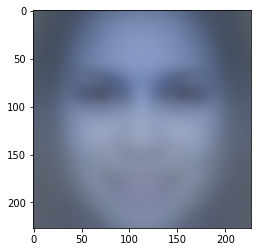

In [6]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [7]:

X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_validation-mean_img, X_test-mean_img

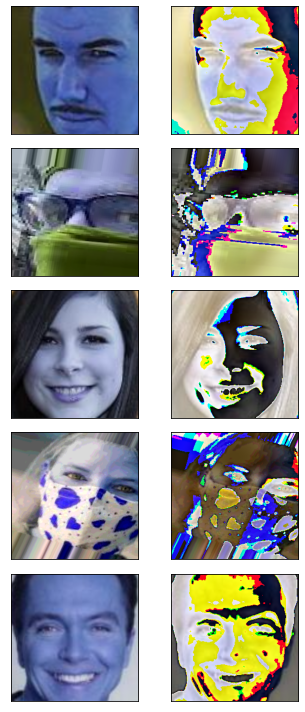

In [8]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [9]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

In [10]:

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)
h = model.fit(x=X_train_norm, y=Y_train, epochs=20, validation_data=(X_valid_norm, Y_validation), batch_size=32)

Epoch 1/20
313/313 [==============================] - 144s 461ms/step - loss: 0.1495 - accuracy: 0.9546 - val_loss: 0.0868 - val_accuracy: 0.9750
Epoch 2/20
313/313 [==============================] - 143s 457ms/step - loss: 0.0941 - accuracy: 0.9720 - val_loss: 0.0468 - val_accuracy: 0.9825
Epoch 3/20
313/313 [==============================] - 144s 459ms/step - loss: 0.0759 - accuracy: 0.9798 - val_loss: 0.0500 - val_accuracy: 0.9800
Epoch 4/20
313/313 [==============================] - 143s 458ms/step - loss: 0.0736 - accuracy: 0.9797 - val_loss: 0.0486 - val_accuracy: 0.9812
Epoch 5/20
313/313 [==============================] - 144s 459ms/step - loss: 0.0637 - accuracy: 0.9837 - val_loss: 0.0548 - val_accuracy: 0.9762
Epoch 6/20
313/313 [==============================] - 145s 462ms/step - loss: 0.0562 - accuracy: 0.9828 - val_loss: 0.0251 - val_accuracy: 0.9887
Epoch 7/20
313/313 [==============================] - 144s 460ms/step - loss: 0.0446 - accuracy: 0.9880 - val_loss: 0.0253 -

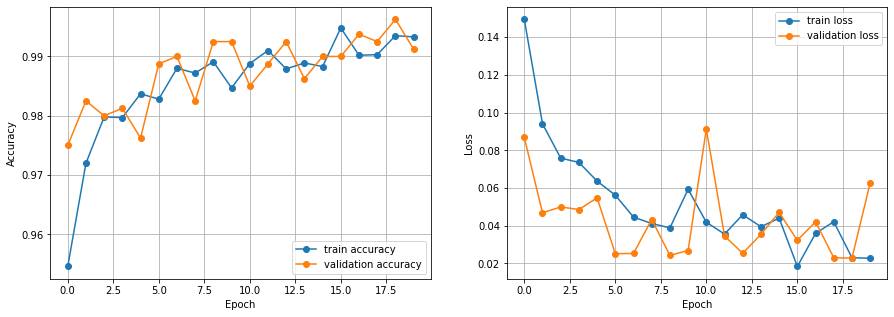

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

31/31 [==============================] - 3s 98ms/step - loss: 0.2299 - accuracy: 0.9859

Test Accuracy: 0.9858871102333069

Test Loss: 0.22991760075092316


In [17]:
model.save('face_mask_alexnet.h5')

In [20]:
model = tf.keras.models.load_model('face_mask_alexnet.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_facemask_alexnet.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\khali\AppData\Local\Temp\tmply3lvmkd\assets


95880468